In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

from osgeo import gdal
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd
import rasterio
import rioxarray as rxr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
plt.rcParams['font.family'] = 'Arial'
from matplotlib.ticker import MaxNLocator

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

In [2]:
# inpath = '/Users/baonili/Desktop/manu1/data/'
inpath = 'C:/Users/bn_li/Desktop/manu1/data/'
# inpath = '/portal1/dell/li-b/manu1/data/'
outpath = 'D:/figs_manu1/'

In [3]:
ds_lai_d1 = xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc')
ds_ndvi_d1 = xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc')
ds_sif_d1 = xr.open_dataset(inpath+'shapley/sif_0.05_1d.nc')
ds_lai_d1.time.values, ds_ndvi_d1.time.values, ds_sif_d1.time.values

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(array(['2000-02-18T00:00:00.000000000', '2000-02-19T00:00:00.000000000',
        '2000-02-20T00:00:00.000000000', ...,
        '2023-12-25T00:00:00.000000000', '2023-12-26T00:00:00.000000000',
        '2023-12-27T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([cftime.DatetimeJulian(2000, 2, 18, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(2000, 2, 19, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(2000, 2, 20, 0, 0, 0, 0, has_year_zero=False),
        ...,
        cftime.DatetimeJulian(2025, 8, 11, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(2025, 8, 12, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeJulian(2025, 8, 13, 0, 0, 0, 0, has_year_zero=False)],
       dtype=object),
 array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
        '2000-01-03T00:00:00.000000000', ...,
        '2022-12-29T00:00:00.000000000', '2022-12-30T00:00:00.000000000',
        '2022-12-31T00:00:00.000000000'], dtype

## veg type mask

In [5]:
## use the drought year 2022 as reference
## regroup types in year 2003, 2013, and 2022 
## select pixels those have been #1 forest, #2 savannas, and #5 cropland throughout 2003, 2013, 2022 as our objects 

In [3]:
### 0-Water, 1-Evergreen Needleleaf, 2-Evergreen Broadleaf, 3-Deciduous Needleleaf, 4-Deciduous Broadleaf, 5-Mixed Forests, 
# 6-Closed Shrublands, 7-Open Shrublands, 8-Woody Savannas, 9-Savannas, 10-Grasslands, 11-Permanent Wetlands, 
# 12-Croplands, 13-Urban, 14-Cropland/Natural Mosaics, 15-Permanent Snow and Ice, 16-Barren

mask = xr.open_dataset(inpath+'LC_IGBP_2022_epsg4326.tif')
aa = mask['band_data'][0,:,:].values
data = {'Category': aa[~np.isnan(aa)].ravel()}
df = pd.DataFrame(data)

value_counts = df['Category'].value_counts()
value_counts
## regroup 12-crop 14-mosaics into #5 cropland
## regroup 1- 2-evergreen broadleaf 4-deciduous broadleaf 5-mixed forest into #1 forest
## regroup 8-woody savannas 9-savannas into #2 savannas

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Category
12.0    9646
8.0     8999
9.0     7893
0.0     5543
2.0     4178
14.0    2414
5.0     2210
13.0    1728
4.0      897
11.0     186
1.0      163
10.0      31
16.0       2
Name: count, dtype: int64

In [12]:
mask = xr.open_dataset('C:/Users/bn_li/Desktop/manu1/data/LC_IGBP_2022_epsg4326.tif')
aa = mask['band_data'][0,:,:].values

# Flatten and remove NaNs
data = {'Category': aa[~np.isnan(aa)].ravel()}
df = pd.DataFrame(data)

# Compute value counts
value_counts = df['Category'].value_counts()

# Compute percentage
percentage = df['Category'].value_counts(normalize=True) * 100

# Combine into one DataFrame
result = pd.DataFrame({
    'Count': value_counts,
    'Percentage': percentage
})

# Optional: sort by Category
result = result.sort_index()

print(result)

          Count  Percentage
Category                   
0.0        5543   12.629301
1.0         163    0.371383
2.0        4178    9.519253
4.0         897    2.043746
5.0        2210    5.035316
8.0        8999   20.503532
9.0        7893   17.983595
10.0         31    0.070631
11.0        186    0.423787
12.0       9646   21.977671
13.0       1728    3.937116
14.0       2414    5.500114
16.0          2    0.004557


In [17]:
result['Count'].sum()

43890

In [3]:
mask = xr.open_dataset(inpath + 'lc.nc')
mask1 = xr.open_dataset(inpath+'spi_mask.nc')

def varimask_forest(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 1
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Forest mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        arr = vari_masked.copy() #### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

def varimask_shrub(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 2
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Shrubland mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        anos[t,:,:] = vari_masked
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)


def varimask_crop(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 5
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Crop mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        anos[t,:,:] = vari_masked
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## VI temporal interpolation & calculate jas anomalies & normalized

In [11]:
def interpo_daily(ds_y0):
    ds_re = ds_y0['vari'].resample(time='D').asfreq().to_dataset()
    times = ds_re['time'].values
    lats = ds_y0['lat'].values
    lons = ds_y0['lon'].values
    x_n = ds_y0.dims['lat']
    y_n = ds_y0.dims['lon']

    arr = np.full((len(times), x_n, y_n), np.nan)

    for j in range(x_n):      # lat
        for i in range(y_n):  # lon
            s0 = ds_re['vari'][:, j, i].values
            s_interp = pd.Series(s0).interpolate(method='linear', limit_direction='both')
            arr[:, j, i] = s_interp.values

    ds_y00 = xr.Dataset(
        {'vari': (['time', 'lat', 'lon'], arr)},
        coords={'time': times, 'lat': lats, 'lon': lons}
    )

    return ds_y00

In [13]:
ds_lai0 = xr.open_dataset(inpath+'new/lai_new_qc_0.05.nc')
ds_lai_d = interpo_daily(ds_lai0)

ds_sif0 = xr.open_dataset(inpath+'new/sif_0.05.nc')
ds_sif_d = interpo_daily(ds_sif0)

ds_ndvi0 = xr.open_dataset(inpath+'new/ndvi_new_qc_0.05.nc')
ds_ndvi_d = interpo_daily(ds_ndvi0)

C:\Users\bn_li\AppData\Local\Temp\ipykernel_17436\3277898219.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x_n = ds_y0.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_17436\3277898219.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y_n = ds_y0.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_17436\3277898219.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x_n = d

In [17]:
vari = ds_lai_d['vari']

# Create a mask for pixels that are all zero over time
all_zero_mask = (vari == 0).all(dim='time')

# Replace those pixels with NaN for all time steps
vari = vari.where(~all_zero_mask, np.nan)

# Update the dataset
ds_lai_d['vari'] = vari

In [23]:
ds_lai_d.to_netcdf(inpath+'shapley/lai_new_qc_0.05_1d.nc')
ds_sif_d.to_netcdf(inpath+'shapley/sif_0.05_1d.nc')
ds_ndvi_d.to_netcdf(inpath+'shapley/ndvi_new_qc_0.05_1d.nc')

In [4]:
############# caution that veg index anomalies has been normalized ########################################
from sklearn.preprocessing import MaxAbsScaler
def cal_3month_ano_aver(ds1, mon1, mon2, mon3, start_year, end_year):
    ds_m00 = ds1.resample(time='M').mean(skipna=True)
    ds_m0 = ds_m00.sel(time=ds_m00['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values
    anos = np.zeros_like(ds_m)
    anos1 = np.zeros_like(ds_m) #contain detrended and normalized anomalies
    scaler = MaxAbsScaler()
    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(start_year, end_year+1)
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing' or tr=='decreasing':
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                    anos1[:,j,i] = scaler.fit_transform(anos[:, j, i].reshape(-1, 1)).flatten()
                else:
                    anos[:,j,i] = v1 - v1.mean()
                    anos1[:,j,i] = scaler.fit_transform(anos[:, j, i].reshape(-1, 1)).flatten()
            else:
                anos[:,j,i] = v1 - v1.mean()
                anos1[:,j,i] = scaler.fit_transform(anos[:, j, i].reshape(-1, 1)).flatten()
    times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')           
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos1)},
                        coords={'time': (['time'], times), 
                                'lat': (['lat'], ds1.lat.values),
                        'lon': (['lon'], ds1.lon.values)})
    return ds_ano

In [ ]:
ds_lai_d1 = xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01', '2022-12-31'))
ds_ndvi_d1 = xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01', '2022-12-31'))
ds_sif_d1 = xr.open_dataset(inpath+'shapley/sif_0.05_1d.nc').sel(time=slice('2001-01-01', '2022-12-31'))
var_data = datasets['y2']['vari']


In [7]:
# ds_lai_d1 = ds_lai_d.sel(time=slice('2003-01-01', '2022-12-31'))
# ds_ndvi_d1 = ds_ndvi_d.sel(time=slice('2003-01-01', '2022-12-31'))
# ds_sif_d1 = ds_sif_d.sel(time=slice('2003-01-01', '2022-12-31'))

ds_lai = cal_3month_ano_aver(ds_lai_d1, 7, 8, 9, 2001, 2022)
ds_ndvi = cal_3month_ano_aver(ds_ndvi_d1, 7, 8, 9, 2001, 2022)
ds_sif = cal_3month_ano_aver(ds_sif_d1, 7, 8, 9, 2001, 2022)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\sklearn\utils\_array_api.py:712: RuntimeWarning: All-NaN 

In [9]:
ds_lai.to_netcdf(inpath+'lai_ano.nc')
ds_ndvi.to_netcdf(inpath+'ndvi_ano.nc')
ds_sif.to_netcdf(inpath+'sif_ano.nc')
######## all anos are normalized

## plot jas 2022 anomalies spatial

In [10]:
# ds_ndvi = xr.open_dataset(inpath+'anos/ndvi_ano.nc')
# ds_sif = xr.open_dataset(inpath+'anos/sif_ano.nc')
# ds_lai = xr.open_dataset(inpath+'anos/lai_ano.nc')

ndvi1 = ds_ndvi['vari'][21,:,:].values
ndvi2 = np.flip(ndvi1, axis=0)
sif1 = ds_sif['vari'][21,:,:].values
sif2 = np.flip(sif1, axis=0)
lai1 = ds_lai['vari'][21,:,:].values
lai2 = np.flip(lai1, axis=0)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

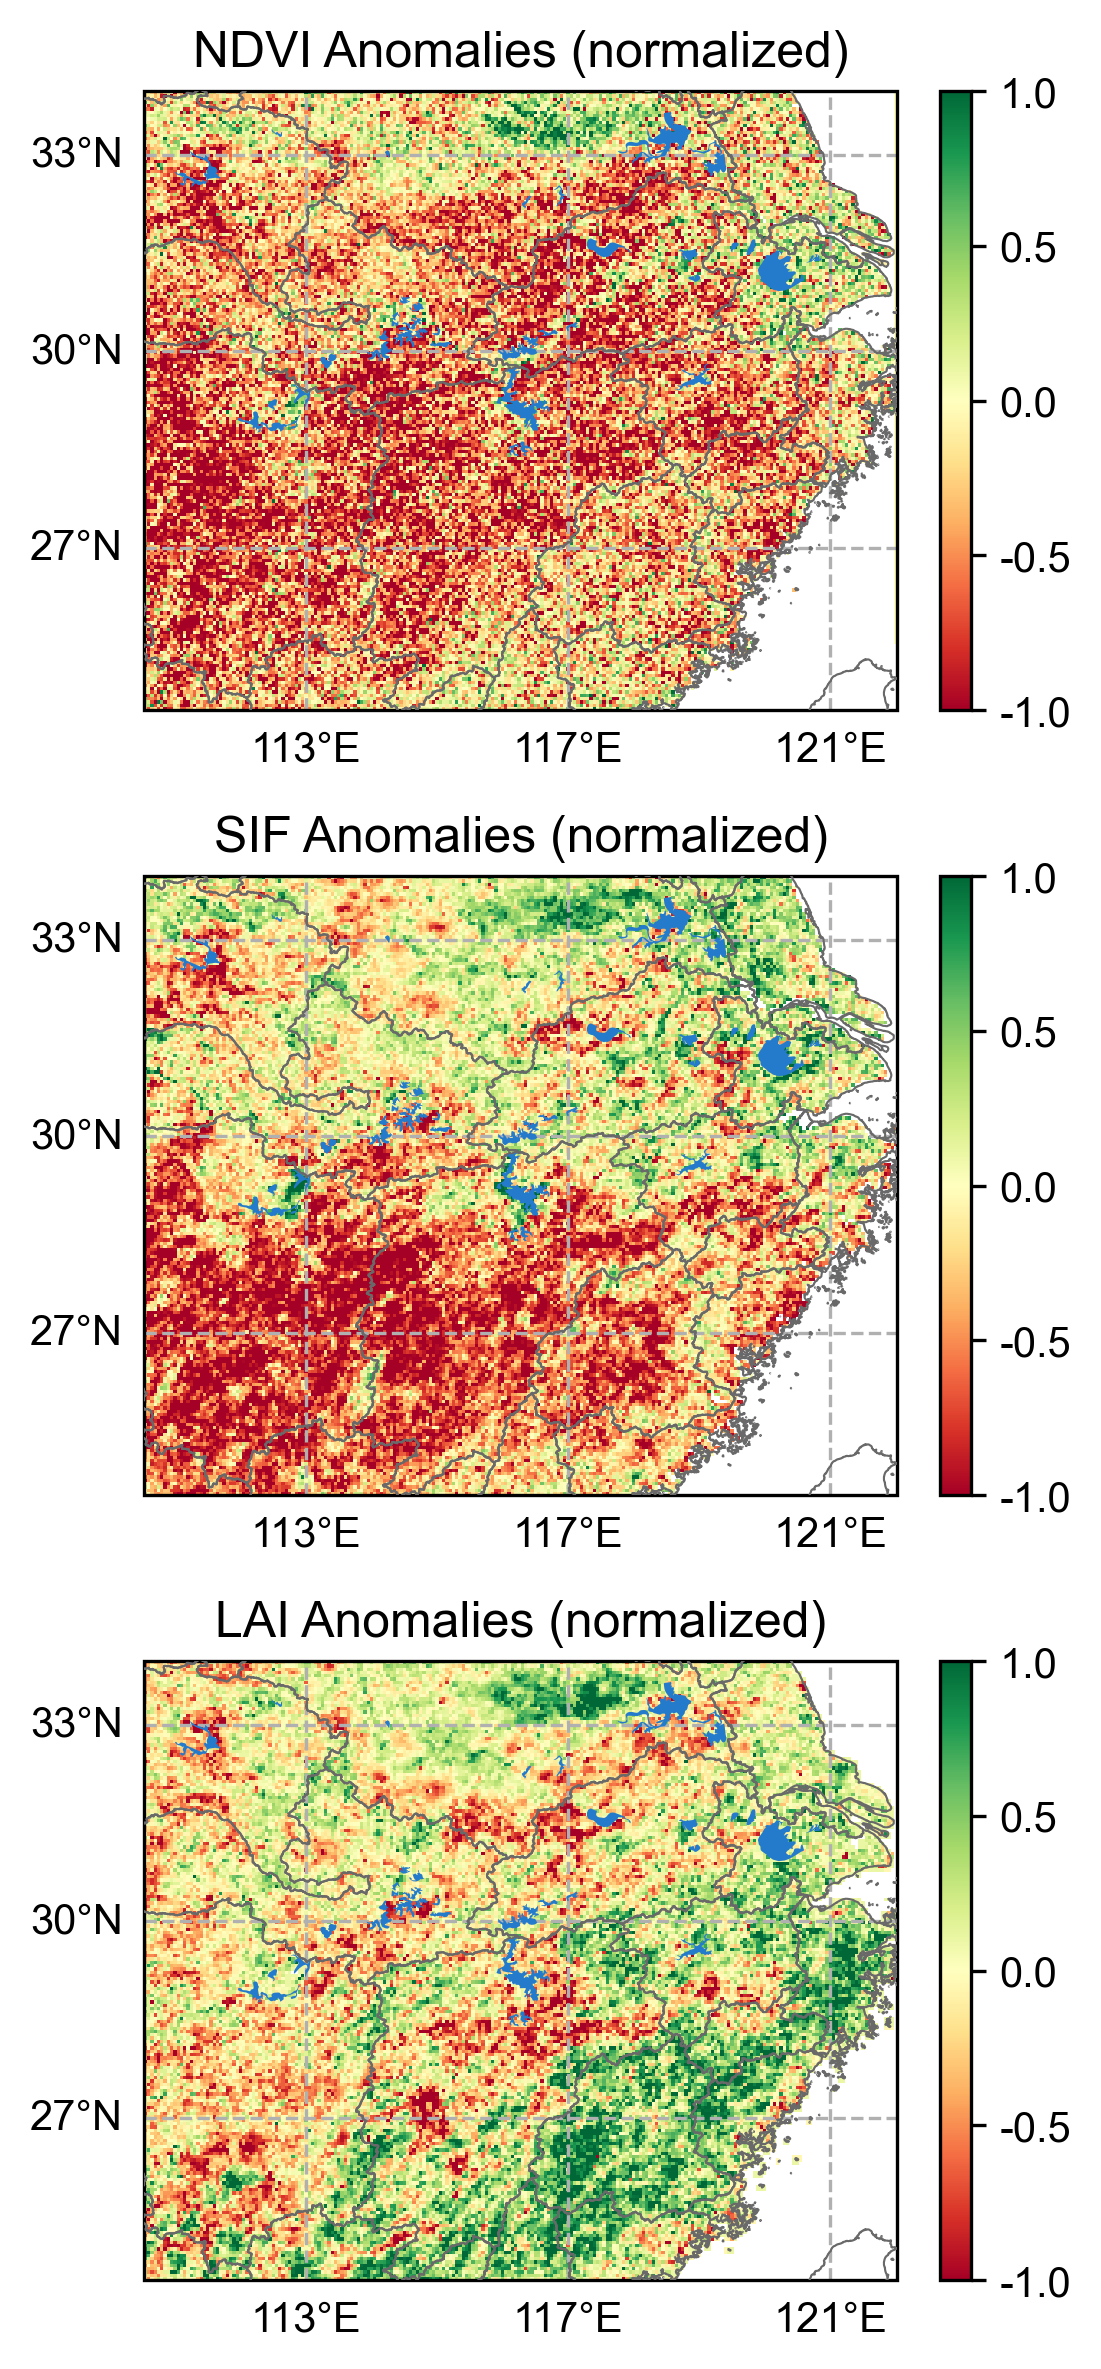

In [11]:
shp_bound = inpath+'shp/basin_lev05.shp'

latitude, longitude = ds_ndvi.lat.values, ds_ndvi.lon.values
extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()]
lon_lc = np.linspace(110.5,122,231)
lat_lc = np.linspace(24.5,34,190)

fig, axes = plt.subplots(3, 1, figsize=(5, 8), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
x_ticks = np.arange(109, 124, 4)  # Longitude ticks every 3 degrees
y_ticks = np.arange(24, 34, 3)    # Latitude ticks every 2 degrees
vmax=1
vmin=-1
cmap = plt.get_cmap('RdYlGn')

for i, ax in enumerate(axes):
    ax.set_extent(extent, crs=ccrs.Geodetic())
    if i == 0:
        data = ndvi2
        title = 'NDVI Anomalies (normalized)'
    elif i == 1:
        data = sif1
        title = 'SIF Anomalies (normalized)'
    elif i == 2:
        data = lai2
        title = 'LAI Anomalies (normalized)'    
    pcm = ax.pcolormesh(lon_lc, lat_lc, data, transform=ccrs.PlateCarree(), cmap=cmap, vmax=vmax, vmin=vmin)
    gridlines = ax.gridlines(draw_labels=True, linestyle='--')
    gridlines.xlabels_top = None
    gridlines.ylabels_right = None
    gridlines.xlocator = mticker.FixedLocator(x_ticks)
    gridlines.ylocator = mticker.FixedLocator(y_ticks)
    # Read and plot the boundary shapefile
    reader_bound = shapereader.Reader(shp_bound)
    geometries_bound = list(reader_bound.geometries())
    ax.add_geometries(geometries_bound, crs=ccrs.PlateCarree(), edgecolor='dimgrey', facecolor='none', lw=0.5,zorder=3)
    # Read and plot the river shapefile
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#257bcb',zorder= 15)
    ax.set_title(title, fontsize=12)
    
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, aspect=20)
    ticks = np.linspace(vmin, vmax, 5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{t:.1f}' for t in ticks])

plt.subplots_adjust(hspace=0.3)  # Adjust vertical spacing between subplots
plt.tight_layout()
plt.savefig(outpath+'3a.eps', dpi=300, bbox_inches='tight') 
plt.show()

## area-mean 

In [12]:
ndvif = varimask_forest(ds_ndvi)
ndvis = varimask_shrub(ds_ndvi)
ndvic = varimask_crop(ds_ndvi)
siff = varimask_forest(ds_sif)
sifs = varimask_shrub(ds_sif)
sifc = varimask_crop(ds_sif)
laif = varimask_forest(ds_lai)
lais = varimask_shrub(ds_lai)
laic = varimask_crop(ds_lai)

Forest mask ratio: 84.22%
Shrubland mask ratio: 87.93%
Crop mask ratio: 41.56%
Forest mask ratio: 84.22%
Shrubland mask ratio: 87.93%
Crop mask ratio: 41.56%
Forest mask ratio: 84.22%
Shrubland mask ratio: 87.93%
Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_10740\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_10740\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_10740\2105116616.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(d

In [13]:
nt = ds_ndvi['vari'].mean(dim=['lat','lon'],skipna=True).values
nf = ndvif['vari'].mean(dim=['lat','lon'],skipna=True).values
ns = ndvis['vari'].mean(dim=['lat','lon'],skipna=True).values
nc = ndvic['vari'].mean(dim=['lat','lon'],skipna=True).values
st = ds_sif['vari'].mean(dim=['lat','lon'],skipna=True).values
sf = siff['vari'].mean(dim=['lat','lon'],skipna=True).values
ss = sifs['vari'].mean(dim=['lat','lon'],skipna=True).values
sc = sifc['vari'].mean(dim=['lat','lon'],skipna=True).values
lt = ds_lai['vari'].mean(dim=['lat','lon'],skipna=True).values
lf = laif['vari'].mean(dim=['lat','lon'],skipna=True).values
ls = lais['vari'].mean(dim=['lat','lon'],skipna=True).values
lc = laic['vari'].mean(dim=['lat','lon'],skipna=True).values

times = pd.date_range('2001','2023',freq='Y')
df = pd.DataFrame({'time':times,'nt':nt, 'nf':nf, 'ns':ns,'nc':nc, 'st':st, 'sf':sf, 'ss':ss,'sc':sc,'lt':lt, 'lf':lf, 'ls':ls,'lc':lc})
df.set_index('time', inplace=True)
df

C:\Users\bn_li\AppData\Local\Temp\ipykernel_10740\658614236.py:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range('2001','2023',freq='Y')


nt        nf        ns        nc        st        sf  \
time                                                                     
2001-12-31 -0.139002  0.066788 -0.035260 -0.375570 -0.084399 -0.163116   
2002-12-31  0.009595  0.025099  0.076178 -0.041688 -0.022145 -0.026944   
2003-12-31 -0.244128 -0.198338 -0.334933 -0.315393 -0.265243 -0.260022   
2004-12-31 -0.039766 -0.137931 -0.112222  0.064723 -0.217793 -0.138742   
2005-12-31  0.010129 -0.034390 -0.072107  0.088382 -0.050503  0.034834   
2006-12-31 -0.065093 -0.090241 -0.072095 -0.037594  0.130437  0.136051   
2007-12-31  0.098189  0.029300  0.062911  0.190483 -0.025640 -0.080081   
2008-12-31 -0.042063 -0.270598 -0.046911  0.137911  0.026490  0.043160   
2009-12-31 -0.026502 -0.090497 -0.022784 -0.070846  0.149281  0.211187   
2010-12-31  0.089519 -0.045032  0.072382  0.184855  0.156400  0.185853   
2011-12-31  0.084168  0.054483  0.035434  0.213090 -0.035103 -0.049912   
2012-12-31  0.138072  0.088774  0.170719  0.152596  0.205204  0.153705   
2013-12-31  0.025825  0.095199 -0.020462 -0.024249  0.065838 -0.036462   
2014-12-31  0.102491 -0.015551  0.132305  0.245690  0.036133 -0.070144   
2015-12-31  0.139413  0.188905  0.276098  0.031505  0.034478 -0.042759   
2016-12-31  0.023132  0.178817  0.086672 -0.110579  0.064053  0.002039   
2017-12-31  0.151306  0.168901  0.157128  0.178919  0.303551  0.324832   
2018-12-31 -0.019964  0.088892  0.063425 -0.056641 -0.033385 -0.080598   
2019-12-31 -0.090173  0.008197 -0.069007 -0.161280 -0.138993 -0.103444   
2020-12-31  0.063330  0.106072  0.071699  0.046947 -0.108912 -0.142536   
2021-12-31  0.092192  0.105968  0.109261  0.139159  0.054399  0.151635   
2022-12-31 -0.360670 -0.322817 -0.528433 -0.480418 -0.244148 -0.048538   

                  ss        sc        lt        lf        ls        lc  
time                                                                    
2001-12-31 -0.170139 -0.199156 -0.112049  0.053509 -0.111497 -0.371852  
2002-12-31 -0.084551 -0.065818 -0.083248 -0.255224 -0.138433 -0.069230  
2003-12-31 -0.252317 -0.303129 -0.183285  0.237681 -0.040271 -0.473271  
2004-12-31 -0.199331 -0.229820 -0.148480 -0.173556 -0.276654 -0.128627  
2005-12-31  0.038676 -0.143212 -0.144341 -0.204011 -0.220489 -0.053265  
2006-12-31  0.135240  0.185149  0.092568  0.123966  0.139560  0.113017  
2007-12-31  0.038713  0.034692  0.107964 -0.085842  0.047208  0.363568  
2008-12-31  0.076039  0.107930  0.001042 -0.148203  0.008412  0.136415  
2009-12-31  0.163922  0.170424 -0.003848 -0.111347  0.065619 -0.012190  
2010-12-31  0.192182  0.159161  0.061629 -0.120321  0.041341  0.160135  
2011-12-31  0.014346 -0.017445  0.071720  0.031857  0.073053  0.205312  
2012-12-31  0.198639  0.256424  0.095352 -0.087022  0.127273  0.183523  
2013-12-31  0.016519  0.078291  0.260631  0.395219  0.248185  0.190939  
2014-12-31 -0.019608  0.078636 -0.077597 -0.353883 -0.090775  0.078558  
2015-12-31  0.007192  0.136797  0.137749 -0.118844  0.172889  0.215313  
2016-12-31 -0.026732  0.183089  0.056424  0.105511  0.077273 -0.029057  
2017-12-31  0.271661  0.309956  0.073206  0.268590  0.082959  0.035137  
2018-12-31 -0.037182  0.017059 -0.060103  0.018493 -0.010408 -0.050212  
2019-12-31 -0.199891 -0.268172  0.069139  0.297810  0.160752 -0.092598  
2020-12-31 -0.167082 -0.113081 -0.239488 -0.281590 -0.297788 -0.293778  
2021-12-31  0.163630  0.043706 -0.023720 -0.119857 -0.018434  0.079210  
2022-12-31 -0.159925 -0.421481  0.048736  0.527063 -0.039775 -0.187048

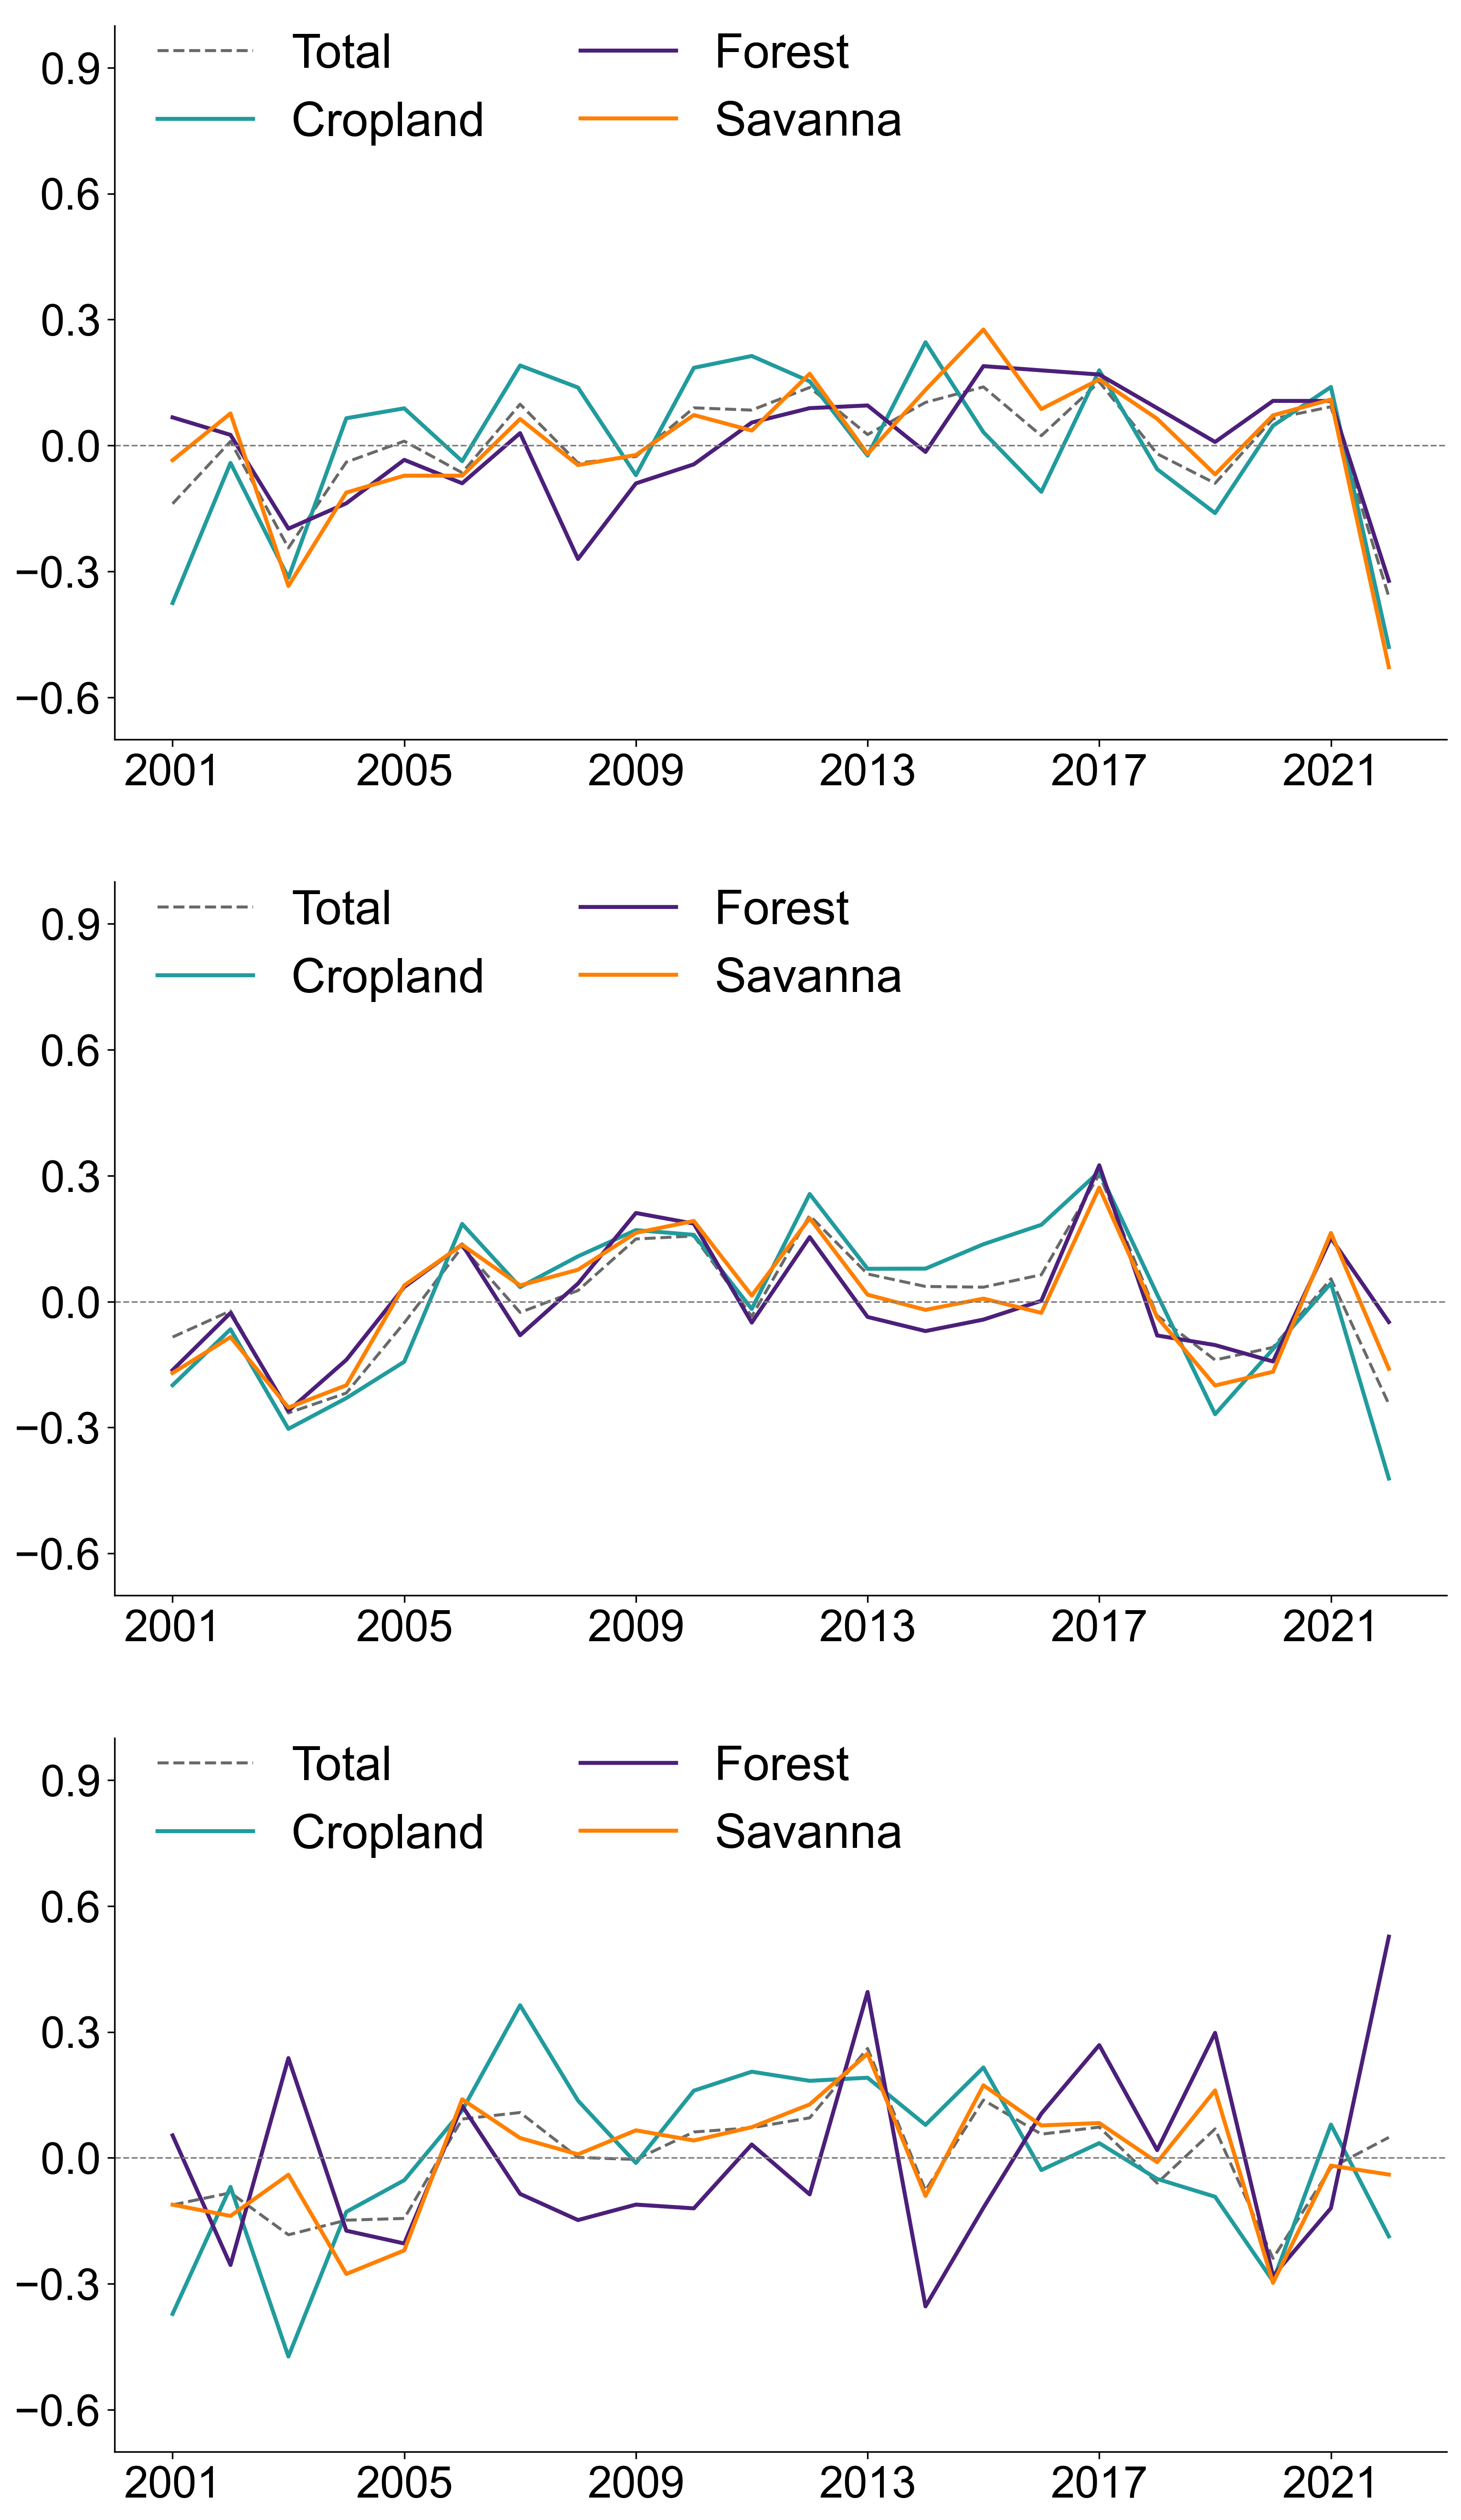

In [14]:
date = np.arange(2001,2023)
v1 = df['nt']
v2 = df['nf']
v3 = df['ns']
v4 = df['nc']
v5 = df['st']
v6 = df['sf']
v7 = df['ss']
v8 = df['sc']
v9 = df['lt']
v10 = df['lf']
v11 = df['ls']
v12 = df['lc']

fig, ax = plt.subplots(3,1,dpi=300,figsize=(12,22))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].plot(date, v1,color='dimgrey',lw=1.5, ls='--', label='Total')
ax[0].plot(date, v4,color='#219B9D',lw=2, ls='-', label='Cropland')
ax[0].plot(date, v2,color='#4C1F7A',lw=2, ls='-', label='Forest')
ax[0].plot(date, v3,color='#FF8000',lw=2, ls='-', label='Savanna')
# ax[0].set_ylabel('NDVI Anomalies (normalized)',fontsize=24) 
custom_ticks = np.arange(2001, 2022, step=4)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels
ax[0].set_xticks(custom_ticks)
ax[0].set_xticklabels(custom_tick_labels, fontsize=22)
ax[0].axhline(y=0, color='gray', linestyle='--',lw=0.8)
ax[0].set_xlim(date[0]-1, date[-1]+1)
ax[0].legend(loc='upper left', bbox_to_anchor=(0,1.05), ncol=2, frameon=False, fontsize=24)
ax[0].set_ylim(-0.7,1)
ax[0].tick_params(axis='y', labelsize=22)
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=6))


ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].plot(date, v5,color='dimgrey',lw=1.5, ls='--', label='Total')
ax[1].plot(date, v8,color='#219B9D',lw=2, ls='-', label='Cropland')
ax[1].plot(date, v6,color='#4C1F7A',lw=2, ls='-', label='Forest')
ax[1].plot(date, v7,color='#FF8000',lw=2, ls='-', label='Savanna')
# ax[1].set_ylabel('SIF Anomalies (normalized)',fontsize=24) 
custom_ticks = np.arange(2001, 2022, step=4)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels
ax[1].set_xticks(custom_ticks)
ax[1].set_xticklabels(custom_tick_labels, fontsize=22)
ax[1].axhline(y=0, color='gray', linestyle='--',lw=0.8)
ax[1].set_xlim(date[0]-1, date[-1]+1)
ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1.05), ncol=2, frameon=False, fontsize=24)
ax[1].set_ylim(-0.7,1)
ax[1].tick_params(axis='y', labelsize=22)
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=6))

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].plot(date, v9,color='dimgrey',lw=1.5, ls='--', label='Total')
ax[2].plot(date, v12,color='#219B9D',lw=2, ls='-', label='Cropland')
ax[2].plot(date, v10,color='#4C1F7A',lw=2, ls='-', label='Forest')
ax[2].plot(date, v11,color='#FF8000',lw=2, ls='-', label='Savanna')
# ax[2].set_ylabel('LAI Anomalies (normalized)',fontsize=24) 
custom_ticks = np.arange(2001, 2022, step=4)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels
ax[2].set_xticks(custom_ticks)
ax[2].set_xticklabels(custom_tick_labels, fontsize=22)
ax[2].axhline(y=0, color='gray', linestyle='--',lw=0.8)
ax[2].set_xlim(date[0]-1, date[-1]+1)
ax[2].legend(loc='upper left', bbox_to_anchor=(0, 1.05), ncol=2, frameon=False, fontsize=24)
ax[2].set_ylim(-0.7,1)
ax[2].tick_params(axis='y', labelsize=22)
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=6))

plt.subplots_adjust(wspace=0.08)
plt.savefig(outpath+'3b.eps', dpi=1000, bbox_inches='tight') 
plt.show()

In [15]:
std_values = df.std()
mean_values = df.mean()
last_row = df.iloc[-1]
distance_from_std = (last_row - mean_values) / std_values
print(distance_from_std)

nt   -2.849791
nf   -2.315755
ns   -3.085397
nc   -2.451263
st   -1.697634
sf   -0.341628
ss   -1.072595
sc   -2.156823
lt    0.404806
lf    2.286626
ls   -0.275782
lc   -0.913035
dtype: float64


In [10]:
distance_from_std.iloc[4:8].values

array([-1.51715559, -0.30931661, -1.20843135, -2.10990498])

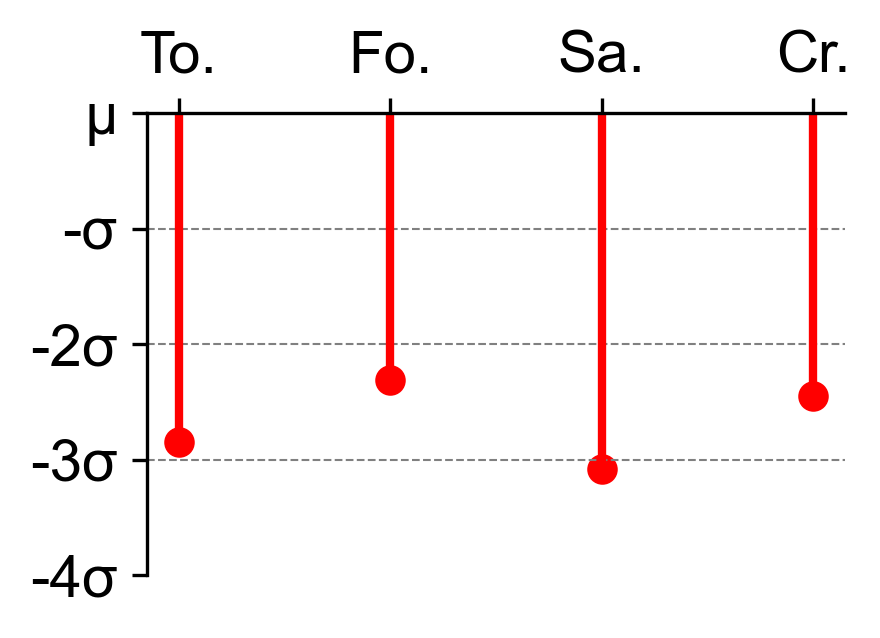

In [16]:
fig, ax = plt.subplots(1,1,dpi=300,figsize=(3,2))
ax.spines['bottom'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)  # Enable labels on the top, disable on the bottom
ax.tick_params(top=True, bottom=False)
data = distance_from_std.iloc[0:4].values
x = [1, 2, 3, 4]
y = data
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-3, color='grey', linestyle='--', linewidth=0.5)
# plt.scatter(x, y, marker='+', color='r', s=80)  
ax.vlines(x, ymin=data, ymax=0, color='r', linewidth=2)  
ax.scatter(x, data, color='r', s=40)  # Add small points at the end of the lines
xticks = [1, 2, 3, 4]  
xticklabels = ['To.', 'Fo.', 'Sa.', 'Cr.']  
ax.set_xticks(xticks) 
ax.set_xticklabels(xticklabels, fontsize=14)
ax.set_ylim(-4,0)
yticks = [-4, -3, -2, -1, 0]  
yticklabels = ['-4σ','-3σ', '-2σ', '-σ', 'μ']  
ax.set_yticks(yticks) 
ax.set_yticklabels(yticklabels, fontsize=14)
plt.savefig(outpath+'3b_1.eps', dpi=1000, bbox_inches='tight') 
plt.show()

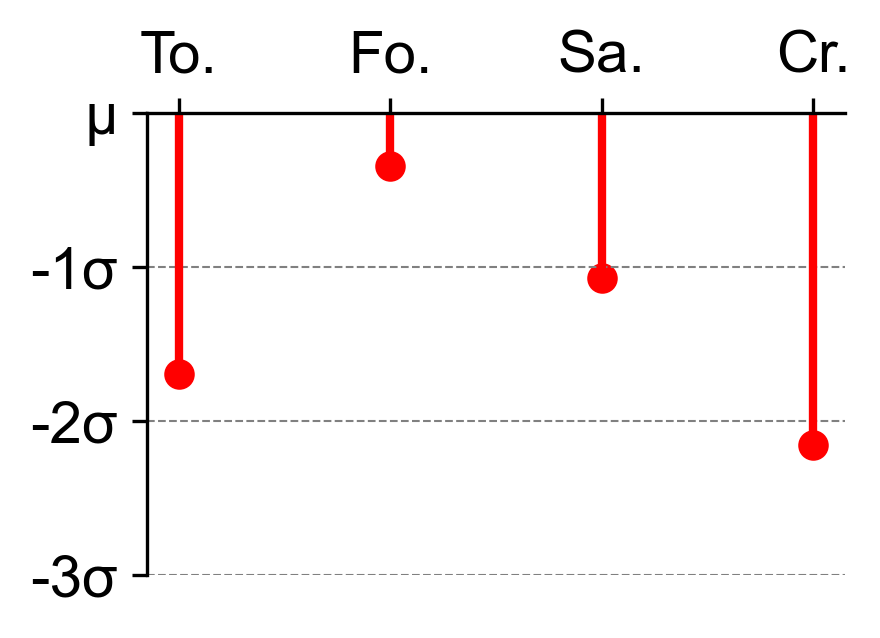

In [17]:
fig, ax = plt.subplots(1,1,dpi=300,figsize=(3,2))
ax.spines['bottom'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)  # Enable labels on the top, disable on the bottom
ax.tick_params(top=True, bottom=False)
data = distance_from_std.iloc[4:8].values
x = [1, 2, 3, 4]
y = data
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-3, color='grey', linestyle='--', linewidth=0.5)
ax.vlines(x, ymin=data, ymax=0, color='r', linewidth=2)  
ax.scatter(x, data, color='r', s=40)  # Add small points at the end of the lines
xticks = [1, 2, 3, 4]  
xticklabels = ['To.', 'Fo.', 'Sa.', 'Cr.']  
ax.set_xticks(xticks) 
ax.set_xticklabels(xticklabels, fontsize=14)
ax.set_ylim(-3,0)
yticks = [ -3, -2, -1, 0]  
yticklabels = ['-3σ', '-2σ', '-1σ', 'μ']  
ax.set_yticks(yticks) 
ax.set_yticklabels(yticklabels, fontsize=14)
plt.savefig(outpath+'3b_2.eps', dpi=1000, bbox_inches='tight') 
plt.show()

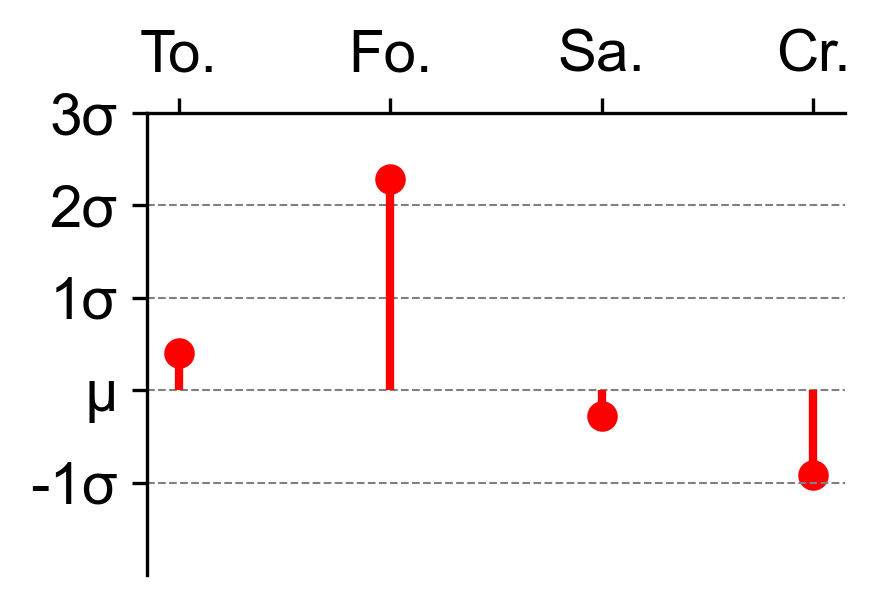

In [18]:
fig, ax = plt.subplots(1,1,dpi=300,figsize=(3,2))
ax.spines['bottom'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)  # Enable labels on the top, disable on the bottom
ax.tick_params(top=True, bottom=False)
data = distance_from_std.iloc[8:12].values
x = [1, 2, 3, 4]
y = data
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
ax.vlines(x, ymin=data, ymax=0, color='r', linewidth=2)  
ax.scatter(x, data, color='r', s=40)  # Add small points at the end of the lines
xticks = [1, 2, 3, 4]  
xticklabels = ['To.', 'Fo.', 'Sa.', 'Cr.']  
ax.set_xticks(xticks) 
ax.set_xticklabels(xticklabels, fontsize=14)
ax.set_ylim(-2,3)
yticks = [ -1, 0, 1,2,3]  
yticklabels = ['-1σ', 'μ','1σ','2σ','3σ']  
ax.set_yticks(yticks) 
ax.set_yticklabels(yticklabels, fontsize=14)
plt.savefig(outpath+'3b_3.eps', dpi=1000, bbox_inches='tight') 
plt.show()

## reduction percentage for VIs

In [8]:
######################## without normalized #############################################
def cal_3month_ano_aver(ds1, mon1, mon2, mon3, start_year, end_year):
    ds_m00 = ds1.resample(time='M').mean(skipna=True)
    ds_m0 = ds_m00.sel(time=ds_m00['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time', skipna=True)
    ds_m = ds_m1['vari'].values
    anos = np.zeros_like(ds_m)
    
    for i in range(ds_m.shape[2]):  # longitude
        for j in range(ds_m.shape[1]):  # latitude
            v1 = ds_m[:, j, i]
            date = np.arange(start_year, end_year + 1)
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                
                if tr == 'increasing' or tr == 'decreasing':
                    # Linear trend
                    slope, intercept, _, _, _ = stats.linregress(date, v1)
                    trend = slope * date + intercept
                    
                    # Avoid dividing by near-zero trend
                    if np.abs(trend).min() < 1e-6:
                        anos[:, j, i] = v1 - trend
                    else:
                        anos[:, j, i] = (v1 - trend) / trend * 100
                        
                else:
                    # No significant trend: percentage anomaly relative to mean
                    mean_val = v1.mean()
                    if np.abs(mean_val) < 1e-6:
                        anos[:, j, i] = v1 - mean_val
                    else:
                        anos[:, j, i] = (v1 - mean_val) / mean_val * 100
                        
            else:
                mean_val = v1.mean()
                if np.abs(mean_val) < 1e-7:
                    anos[:, j, i] = v1 - mean_val
                else:
                    anos[:, j, i] = (v1 - mean_val) / mean_val * 100    
    
    times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')           
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], times), 
                                'lat': (['lat'], ds1.lat.values),
                        'lon': (['lon'], ds1.lon.values)})
    return ds_ano

In [17]:
ds = xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01', '2022-12-31'))
ds789 = cal_3month_ano_aver(ds, 7, 8, 9, 2001, 2022)
ds_fo = varimask_forest(ds789)
ds_sh = varimask_shrub(ds789)
ds_co = varimask_crop(ds789)
to = ds789['vari'].mean(dim=['lat','lon'],skipna=True).values
fo = ds_fo['vari'].mean(dim=['lat','lon'],skipna=True).values
sh = ds_sh['vari'].mean(dim=['lat','lon'],skipna=True).values
co = ds_co['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2001','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'to':to, 'fo':fo,'sh':sh, 'co':co})
df1

<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


Forest mask ratio: 84.22%
Shrubland mask ratio: 87.93%
Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\3854982620.py:44: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:17: FutureWar

time         to        fo        sh        co
0  2001-12-31  -2.804283  0.503901 -0.099373 -4.651601
1  2002-12-31   1.085477  0.197432  0.772479 -0.784409
2  2003-12-31  -2.933523 -1.076128 -2.945729 -4.243417
3  2004-12-31 -14.667638 -0.724754 -0.766204  1.148760
4  2005-12-31  -4.047723 -0.221067 -0.637854  2.226897
5  2006-12-31  -0.527127 -0.514161 -0.386728 -0.058361
6  2007-12-31   1.777901  0.125786  0.429069  2.496168
7  2008-12-31  -0.596592 -1.829569 -0.154483  2.032642
8  2009-12-31   3.865294 -0.649663 -0.145739 -0.440525
9  2010-12-31   8.356298 -0.377007  0.352699  1.920588
10 2011-12-31   6.829012  0.279536  0.217697  3.045016
11 2012-12-31   0.743985  0.405111  1.337693  1.988770
12 2013-12-31   4.910588  0.565149 -0.401420  0.143613
13 2014-12-31   5.760390 -0.169128  1.160801  3.059506
14 2015-12-31  10.099500  1.084356  2.278730  0.264266
15 2016-12-31   1.558510  1.122550  0.465072 -1.941786
16 2017-12-31   6.660646  1.070987  1.219560  1.932454
17 2018-12-31  -4.259221  0.560828  0.630940 -0.678691
18 2019-12-31  -1.091804  0.112995 -0.560771 -1.928581
19 2020-12-31  -9.716674  0.685282  0.554789 -0.163035
20 2021-12-31  -3.119443  0.634911  0.906417  1.665547
21 2022-12-31  -8.388158 -1.788596 -4.232439 -5.563478

In [18]:
ds = xr.open_dataset(inpath+'shapley/sif_0.05_1d.nc').sel(time=slice('2001-01-01', '2022-12-31'))
ds789 = cal_3month_ano_aver(ds, 7, 8, 9, 2001, 2022)
ds_fo = varimask_forest(ds789)
ds_sh = varimask_shrub(ds789)
ds_co = varimask_crop(ds789)
to = ds789['vari'].mean(dim=['lat','lon'],skipna=True).values
fo = ds_fo['vari'].mean(dim=['lat','lon'],skipna=True).values
sh = ds_sh['vari'].mean(dim=['lat','lon'],skipna=True).values
co = ds_co['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2001','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'to':to, 'fo':fo,'sh':sh, 'co':co})
df1

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


Forest mask ratio: 84.22%
Shrubland mask ratio: 87.93%
Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\3854982620.py:44: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:17: FutureWar

time        to        fo        sh        co
0  2001-12-31 -1.239465 -5.374992 -1.410207 -2.572867
1  2002-12-31 -0.292139 -0.850494 -0.817509 -2.640886
2  2003-12-31 -4.873511 -8.016878 -4.378059 -5.080174
3  2004-12-31 -2.031817 -1.912247 -1.009148 -3.162179
4  2005-12-31  0.173451 -0.326550  1.906012 -0.962404
5  2006-12-31  1.769944  1.737306  0.919085  4.965365
6  2007-12-31 -1.578260 -4.912394 -0.561985  0.694065
7  2008-12-31  1.169820  5.446789  2.046977  2.089958
8  2009-12-31  1.639777  4.569422  1.618250  2.122359
9  2010-12-31  1.793209  3.154909  2.677559  0.919154
10 2011-12-31  0.360803  4.197422 -0.430505  2.705812
11 2012-12-31  2.582024  4.290006  2.129688  2.511375
12 2013-12-31  0.915147 -1.240562  0.683101  2.147045
13 2014-12-31  1.434485  2.491968  2.323342  0.056833
14 2015-12-31 -0.298272  2.000735  0.291001  2.016047
15 2016-12-31 -0.051018 -0.778451 -1.658428  0.835742
16 2017-12-31  3.908120  3.309162  4.613674  3.758148
17 2018-12-31  0.171075 -0.092694  0.298983 -0.376965
18 2019-12-31 -2.294793 -2.972394 -3.341680 -3.724126
19 2020-12-31 -2.366816 -4.306873 -3.132196 -2.595208
20 2021-12-31  1.478577  2.248697  3.622661 -1.823428
21 2022-12-31 -2.218140 -0.697460 -1.855650 -2.933729

In [30]:
ds = xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc').sel(time=slice('2001-01-01', '2022-12-31'))
ds789 = cal_3month_ano_aver(ds, 7, 8, 9, 2001, 2022)
ds_fo = varimask_forest(ds789)
ds_sh = varimask_shrub(ds789)
ds_co = varimask_crop(ds789)
ds789['vari'] = ds789['vari'].where(np.abs(ds789['vari']) <= 1000)
ds_co['vari'] = ds_co['vari'].where(np.abs(ds_co['vari']) <= 1000)
to = ds789['vari'].mean(dim=['lat','lon'],skipna=True).values
fo = ds_fo['vari'].mean(dim=['lat','lon'],skipna=True).values
sh = ds_sh['vari'].mean(dim=['lat','lon'],skipna=True).values
co = ds_co['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2001','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'to':to, 'fo':fo,'sh':sh, 'co':co})
df1

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


Forest mask ratio: 84.22%
Shrubland mask ratio: 87.93%
Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2449821967.py:44: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_12092\2105116616.py:17: FutureWar

time        to        fo        sh         co
0  2001-12-31 -1.902399  1.020135 -4.068545 -14.230613
1  2002-12-31 -1.514548 -4.669451 -1.784659  -1.495406
2  2003-12-31 -5.698206  4.777690 -0.780265 -11.536607
3  2004-12-31 -2.543650 -3.038944 -4.157647  -2.318579
4  2005-12-31 -2.829365 -3.840948 -3.279033  -0.414605
5  2006-12-31  1.453867  2.074070  2.348839   2.782287
6  2007-12-31  2.487579 -1.639113  1.090379   9.470389
7  2008-12-31  0.039246 -3.035407  0.239319   4.099085
8  2009-12-31 -0.305527 -2.341047  1.198778   0.069735
9  2010-12-31  1.360742 -2.764739  0.684991   4.342664
10 2011-12-31  1.326049  0.313754  1.236440   5.629947
11 2012-12-31  1.951545 -1.653728  2.203218   4.484750
12 2013-12-31  5.433286  7.110303  3.883376   5.503731
13 2014-12-31 -1.612505 -6.626065 -1.283624   1.920178
14 2015-12-31  2.740296 -2.207199  2.796687   4.713920
15 2016-12-31  0.934757  1.970938  1.220268  -1.283070
16 2017-12-31  1.409408  5.060727  1.221451   0.795532
17 2018-12-31 -1.483020  0.379515 -0.165104  -1.537603
18 2019-12-31  0.998544  5.685302  2.466007  -2.168733
19 2020-12-31 -4.082036 -4.613512 -4.551737  -7.081130
20 2021-12-31  0.248183 -1.803021  0.028776   1.851402
21 2022-12-31  1.820878  9.871866 -0.583730  -3.632244

## reduction percentage for hydroclimatic

In [6]:
######################## without normalized #############################################
def cal_3month_ano_sum(ds1, mon1, mon2, mon3, start_year, end_year):
    ds_m00 = ds1.resample(time='M').mean(skipna=True)
    ds_m0 = ds_m00.sel(time=ds_m00['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').sum(dim='time', skipna=True)
    ds_m = ds_m1['vari'].values
    anos = np.zeros_like(ds_m)
    
    for i in range(ds_m.shape[2]):  # longitude
        for j in range(ds_m.shape[1]):  # latitude
            v1 = ds_m[:, j, i]
            date = np.arange(start_year, end_year + 1)
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                
                if tr == 'increasing' or tr == 'decreasing':
                    # Linear trend
                    slope, intercept, _, _, _ = stats.linregress(date, v1)
                    trend = slope * date + intercept
                    
                    # Avoid dividing by near-zero trend
                    if np.abs(trend).min() < 1e-6:
                        anos[:, j, i] = v1 - trend
                    else:
                        anos[:, j, i] = (v1 - trend) / trend * 100
                        
                else:
                    # No significant trend: percentage anomaly relative to mean
                    mean_val = v1.mean()
                    if np.abs(mean_val) < 1e-6:
                        anos[:, j, i] = v1 - mean_val
                    else:
                        anos[:, j, i] = (v1 - mean_val) / mean_val * 100
                        
            else:
                mean_val = v1.mean()
                if np.abs(mean_val) < 1e-7:
                    anos[:, j, i] = v1 - mean_val
                else:
                    anos[:, j, i] = (v1 - mean_val) / mean_val * 100    
    
    times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')           
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], times), 
                                'lat': (['lat'], ds1.lat.values),
                        'lon': (['lon'], ds1.lon.values)})
    return ds_ano

In [7]:
ds1 = xr.open_dataset(inpath+'shapley/pre_0.05.nc').sel(time=slice('2001-01-01', '2022-12-31'))
ds789 = cal_3month_ano_sum(ds1, 7, 8, 9, 2001, 2022)
ds_fo = varimask_forest(ds789)
ds_sh = varimask_shrub(ds789)
ds_co = varimask_crop(ds789)
to = ds789['vari'].mean(dim=['lat','lon'],skipna=True).values
fo = ds_fo['vari'].mean(dim=['lat','lon'],skipna=True).values
sh = ds_sh['vari'].mean(dim=['lat','lon'],skipna=True).values
co = ds_co['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2001','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'to':to, 'fo':fo,'sh':sh, 'co':co})
df1

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


Forest mask ratio: 84.22%
Shrubland mask ratio: 87.93%
Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_21636\2068924722.py:44: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_21636\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_21636\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_21636\2105116616.py:17: FutureWar

time         to         fo         sh         co
0  2001-12-31 -17.822100   3.063272 -13.039847 -39.046257
1  2002-12-31  12.530147  35.166264  33.334770   5.971178
2  2003-12-31 -15.200837 -40.243134 -36.106773 -11.638357
3  2004-12-31  -0.279614   1.065940   1.015570   0.798178
4  2005-12-31   4.068574 -16.265621 -15.958983   6.102572
5  2006-12-31  -1.314614   4.528688   1.150406  -5.676996
6  2007-12-31  10.062557   1.272534   4.137332  10.568723
7  2008-12-31   3.121985  -6.207289  -1.735011  15.068610
8  2009-12-31  -7.823143  -4.429802  -5.908961 -19.168810
9  2010-12-31  14.000190   0.973292   8.414840  32.333202
10 2011-12-31 -13.297284 -15.110860 -20.818756 -20.438261
11 2012-12-31   3.381431   3.856493   8.984887   3.534774
12 2013-12-31 -15.411543 -15.939198 -20.826216 -10.182963
13 2014-12-31  14.162082  17.768190  22.581587  14.553424
14 2015-12-31   6.687547  36.218731  23.316706  -5.828010
15 2016-12-31  16.638695  25.714060  28.613794  32.125027
16 2017-12-31   3.931023  -6.426077  -2.229451  14.679294
17 2018-12-31  -1.323017   8.241396   4.201238 -10.760302
18 2019-12-31 -15.535503   2.319273  -3.133097 -39.362915
19 2020-12-31  35.243534  32.693493  46.163239  67.788506
20 2021-12-31  10.939685  -9.268011  -2.540893  15.095509
21 2022-12-31 -46.780361 -59.025398 -59.661304 -56.555473

In [ ]:
######################## without normalized #############################################
def cal_3month_ano_aver1(ds1, mon1, mon2, mon3, start_year, end_year):
    ds_m00 = ds1.resample(time='M').mean(skipna=True)
    ds_m0 = ds_m00.sel(time=ds_m00['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time', skipna=True)
    ds_m = ds_m1['vari'].values
    anos = np.zeros_like(ds_m)
    
    for i in range(ds_m.shape[2]):  # longitude
        for j in range(ds_m.shape[1]):  # latitude
            v1 = ds_m[:, j, i]
            date = np.arange(start_year, end_year + 1)
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                
                if tr == 'increasing' or tr == 'decreasing':
                    # Linear trend
                    slope, intercept, _, _, _ = stats.linregress(date, v1)
                    trend = slope * date + intercept
                    
                    # Avoid dividing by near-zero trend
                    if np.abs(trend).min() < 1e-6:
                        anos[:, j, i] = v1 - trend
                    else:
                        anos[:, j, i] = (v1 - trend) / trend * 100
                        
                else:
                    # No significant trend: percentage anomaly relative to mean
                    mean_val = v1.mean()
                    if np.abs(mean_val) < 1e-6:
                        anos[:, j, i] = v1 - mean_val
                    else:
                        anos[:, j, i] = (v1 - mean_val) / mean_val * 100
                        
            else:
                mean_val = v1.mean()
                if np.abs(mean_val) < 1e-7:
                    anos[:, j, i] = v1 - mean_val
                else:
                    anos[:, j, i] = (v1 - mean_val) / mean_val * 100    
    
    times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')           
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], times), 
                                'lat': (['lat'], ds1.lat.values),
                        'lon': (['lon'], ds1.lon.values)})
    return ds_ano

In [9]:
ds = xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc').sel(time=slice('2016-01-01', '2022-12-31'))
ds789 = cal_3month_ano_aver1(ds, 7, 8, 9, 2016, 2022)
ds_fo = varimask_forest(ds789)
ds_sh = varimask_shrub(ds789)
ds_co = varimask_crop(ds789)
to = ds789['vari'].mean(dim=['lat','lon'],skipna=True).values
fo = ds_fo['vari'].mean(dim=['lat','lon'],skipna=True).values
sh = ds_sh['vari'].mean(dim=['lat','lon'],skipna=True).values
co = ds_co['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2016','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'to':to, 'fo':fo,'sh':sh, 'co':co})
df1

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


Forest mask ratio: 84.22%
Shrubland mask ratio: 87.93%
Crop mask ratio: 41.56%


C:\Users\bn_li\AppData\Local\Temp\ipykernel_21636\2449821967.py:44: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')
C:\Users\bn_li\AppData\Local\Temp\ipykernel_21636\2105116616.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  x = ds.dims['lon']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_21636\2105116616.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  y = ds.dims['lat']
C:\Users\bn_li\AppData\Local\Temp\ipykernel_21636\2105116616.py:17: FutureWar

time        to         fo        sh         co
0 2016-12-31 -1.276236   1.436966  0.723195   1.627475
1 2017-12-31  2.443612  -1.817175  1.077382   5.238740
2 2018-12-31  2.165172  -0.939228  0.651821   4.582967
3 2019-12-31 -3.613719  -3.843283 -3.056156  -1.454528
4 2020-12-31  1.920195  -5.696318 -0.959917  12.676322
5 2021-12-31  6.467007  12.393749  7.430936  -7.343535
6 2022-12-31 -8.087857  -1.558179 -5.899289 -15.335213